In [4]:
import numpy as np
import scipy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from func_util import *
from func_SE3_generators import *
from scipy.optimize import least_squares, minimize
from io import BytesIO
from PIL import Image

In [21]:
lines = [float(line.rstrip('\n')) for line in open('/tmp/calib.txt')]

nocams = int(lines[0])
print nocams
Pr_l = []
fc_l = []
cc_l = []
wh_l = []
i=1
for j in xrange(nocams):
    fc_l.append(np.array([lines[i], lines[i+1]]).astype(np.float32))
    cc_l.append(np.array([lines[i+2], lines[i+3]]).astype(np.float32))
    wh_l.append(np.array([lines[i+4], lines[i+5]]))
    i += 6    
    #tr = np.array([lines[i], lines[i+1], lines[i+2]]).astype(np.float32)
    #i += 3
    #Rr = np.array([[lines[i  ], lines[i+ 1], lines[i+ 2]],
    #                     [lines[i+ 3], lines[i+ 4], lines[i+ 5]],
    #                     [lines[i+ 6], lines[i+ 7], lines[i+ 8]]]).astype(np.float32)
    #i+=9
    #Pr_l.append(np.concatenate((Rr, tr[:,None]    ), axis=1)) 
    Pr_l.append(np.array(lines[i:(i+16)]).reshape((4,4)))
    i += 16
    #quat = func_dcm2quat(Pr_l[-1][0:3,0:3])
    #quat /= np.linalg.norm(quat)
    #Pr_l[-1][0:3,0:3] = func_quat2dcm(quat)
    #print Pr_l[-1]
    #print np.linalg.det(Pr_l[-1][0:3,0:3])
    

1


In [22]:
def func_invert_transform(Pin):
    P = Pin.copy()
    P[0:3,0:3] = P[0:3,0:3].T # R.T
    P[0:3,3] = np.dot(-P[0:3,0:3], P[0:3,3]) # -R.T * t
    return P

def func_P_to_Rt(P):
    return P[0:3,0:3], P[0:3,3]

def func_comb_vehicle_and_rig_pose(P_glob, P_rig):
    return np.dot(P_glob, P_rig)


In [51]:
frstart = 12500
frend = 13399
P_VO = []
P_GT = []
camno = 0
for fr in xrange(frstart,frend):   
    lines = [float(line.rstrip('\n')) for line in open("/tmp/cam{:02d}_{:06d}_GT_VO_poses.txt".format(camno, fr))]
    P = np.array(lines[0:16]).reshape((4,4))
    P_GT.append(P)
    
    P = np.array(lines[16:]).reshape((4,4))
    P_VO.append(P)

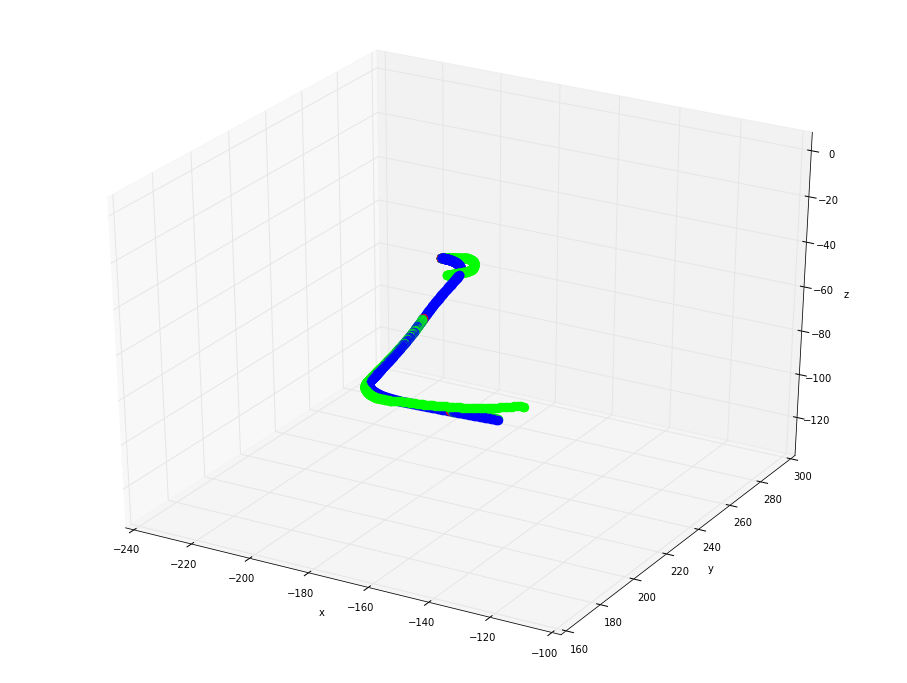

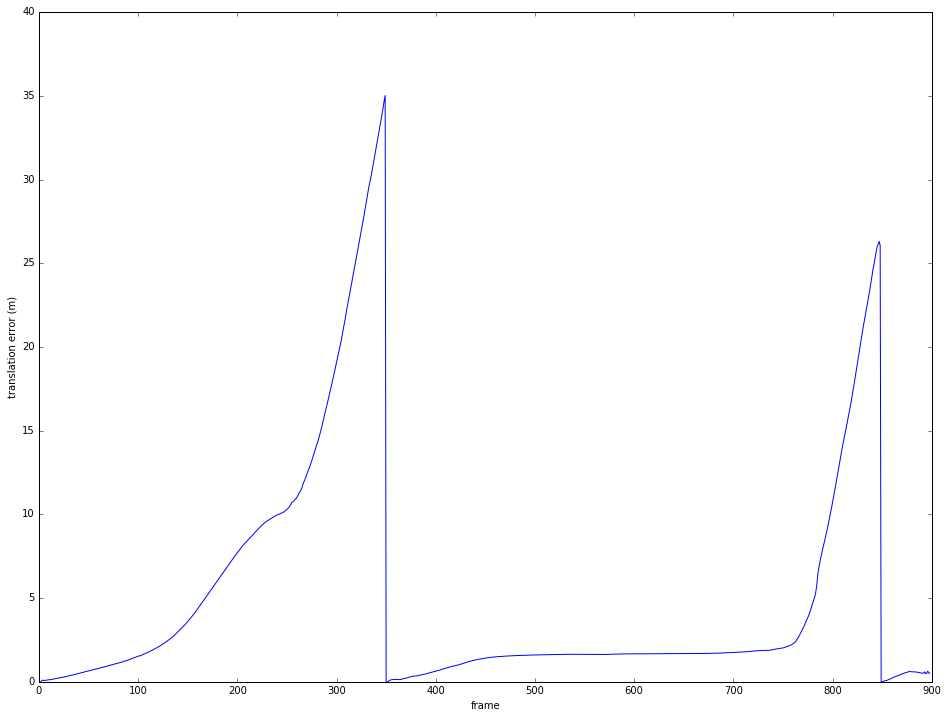

In [54]:
# Display cameras in robot frame
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

camno = 0
err = []
for fr in xrange(0,len(P_GT)):   
    cc = cc_l[camno] - wh_l[camno]/2        
    
    R,t1= func_P_to_Rt(func_comb_vehicle_and_rig_pose(P_GT[fr], Pr_l[camno]))
    #func_plot_cameras(ax, fc_l[camno], cc, wh_l[camno], R, t, rgbface=np.array([0.0, 0.0, 1.0]), camerascaling=1)
    ax.scatter(t1[0],t1[1],t1[2], color=np.array([0.0, 0.0, 1.0]), linewidth=5)
    
    
    R,t2 = func_P_to_Rt(func_comb_vehicle_and_rig_pose(P_VO[fr], Pr_l[camno]))
    camcol = np.array([0.0, 1.0, 0.0])
    if (np.linalg.norm(t1-t2) < 1e-5):
        camcol = np.array([1.0, 0.0, 0.0])
    #func_plot_cameras(ax, fc_l[camno], cc, wh_l[camno], R, t, rgbface=np.array([1.0, 1.0, 0.0]), camerascaling=1)
    ax.scatter(t2[0],t2[1],t2[2], color=camcol, linewidth=5)
    
    err.append(np.linalg.norm(t1-t2))
    

func_set_axes_equal(ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

err = np.array(err)
plt.figure(figsize=(16,12))
plt.plot(xrange(len(P_GT)), err)
plt.ylabel('translation error (m)')
plt.xlabel('frame')
plt.show()


In [ ]:
camno = 0
err = []
for fr in xrange(0,len(P_GT),1):   
